# VQA with Late Modal Fusion

## Setup

In [3]:
%cd "/content/drive/MyDrive/Working/YouTube Channel - Molmobot/VQA with Modal Fusion"
!pwd

/content/drive/MyDrive/Working/YouTube Channel - Molmobot/VQA with Modal Fusion
/content/drive/MyDrive/Working/YouTube Channel - Molmobot/VQA with Modal Fusion


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments, AutoTokenizer, DataCollatorWithPadding, AutoModel, ViTModel, AutoModelForCausalLM, ViTFeatureExtractor
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.transforms as T
from datasets import load_dataset, Dataset

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
IMAGE_ENCODER_MODEL = 'facebook/dino-vitb16'
TEXT_ENCODER_MODEL = 'vinai/phobert-base'
DECODER_MODEL = 'gpt2'

In [15]:
decoder_tokenizer = AutoTokenizer.from_pretrained(DECODER_MODEL)
decoder_tokenizer.pad_token = decoder_tokenizer.eos_token # GPT2 does not have a pad token, so we use the eos token as the pad token
decoder_tokenizer.padding_side = "left" # Default is right

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [16]:
decoder = AutoModelForCausalLM.from_pretrained(DECODER_MODEL).to(device)
decoder

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Building the model

In [17]:
class MultimodalVQAModel(nn.Module):

    def __init__(self, text_encoder_model: str, image_encoder_model: str, decoder_model: str):
        super(MultimodalVQAModel, self).__init__()

        # Load pre-trained models
        self.text_encoder = AutoModel.from_pretrained(text_encoder_model).to(device)
        self.image_encoder = ViTModel.from_pretrained(image_encoder_model).to(device)
        self.decoder = AutoModelForCausalLM.from_pretrained(
            decoder_model,
            add_cross_attention=True,
            tie_word_embeddings=True
        ).to(device)

        # Linear layers to project text and image features to the decoder's hidden size
        self.text_proj = nn.Linear(self.text_encoder.config.hidden_size, self.decoder.config.hidden_size)
        self.image_proj = nn.Linear(self.image_encoder.config.hidden_size, self.decoder.config.hidden_size)

    def forward(self, input_text, input_image, decoder_input_ids, attention_mask, labels=None):
        # Encode text
        text_features = self.encode_text(input_text, attention_mask)
        # Encode image
        image_features = self.encode_image(input_image)

        combined_features = (text_features + image_features) / 2  # Simple average, we can use more complex methods

        # Decoding
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            labels=labels,
            encoder_hidden_states=combined_features.unsqueeze(1),  # Add sequence dimension
        )
        return decoder_outputs

    def encode_text(self, input_text, attention_mask):
        text_outputs = self.text_encoder(input_text, attention_mask=attention_mask)
        # Get the mean pooling of the last hidden state
        text_features = text_outputs.last_hidden_state.mean(dim=1)
        return self.text_proj(text_features)

    def encode_image(self, input_image):
        image_outputs = self.image_encoder(input_image)
        # Get the mean pooling of the last hidden state
        image_features = image_outputs.last_hidden_state.mean(dim=1)
        return self.image_proj(image_features)


## Data Processing

In [7]:
def load_vqa_dataset(filepath: str):
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)

    images = {img["id"]: img["filename"] for img in data["images"]}

    rows = []
    for ann in data["annotations"]:
        row = {
            "image_id": ann["image_id"],
            "question_id": ann["id"],
            "question": ann["question"],
            # Pick the first answer as the "answer", wrap it
            "answer": f"<|endoftext|>{ann['answers'][0]}<|endoftext|>" if ann["answers"] else None,
            "all_answers": ann["answers"],
            "image_filename": f"vitextvqa/st_images/{images.get(ann['image_id'], None)}",
        }
        rows.append(row)

    return rows

In [8]:
TRAIN_DATA_PATH = '/content/drive/MyDrive/Working/YouTube Channel - Molmobot/VQA with Modal Fusion/vitextvqa/ViTextVQA_train.json'
VAL_DATA_PATH = '/content/drive/MyDrive/Working/YouTube Channel - Molmobot/VQA with Modal Fusion/vitextvqa/ViTextVQA_dev.json'
train_data = load_vqa_dataset(TRAIN_DATA_PATH)
val_data = load_vqa_dataset(VAL_DATA_PATH)
val_data[0]

{'image_id': 22,
 'question_id': 74,
 'question': 'cửa tiệm màu xanh là gì ?',
 'answer': '<|endoftext|>nhà thuốc<|endoftext|>',
 'all_answers': ['nhà thuốc'],
 'image_filename': 'vitextvqa/st_images/22.jpg'}

In [10]:
len(train_data), len(val_data)

(35159, 5155)

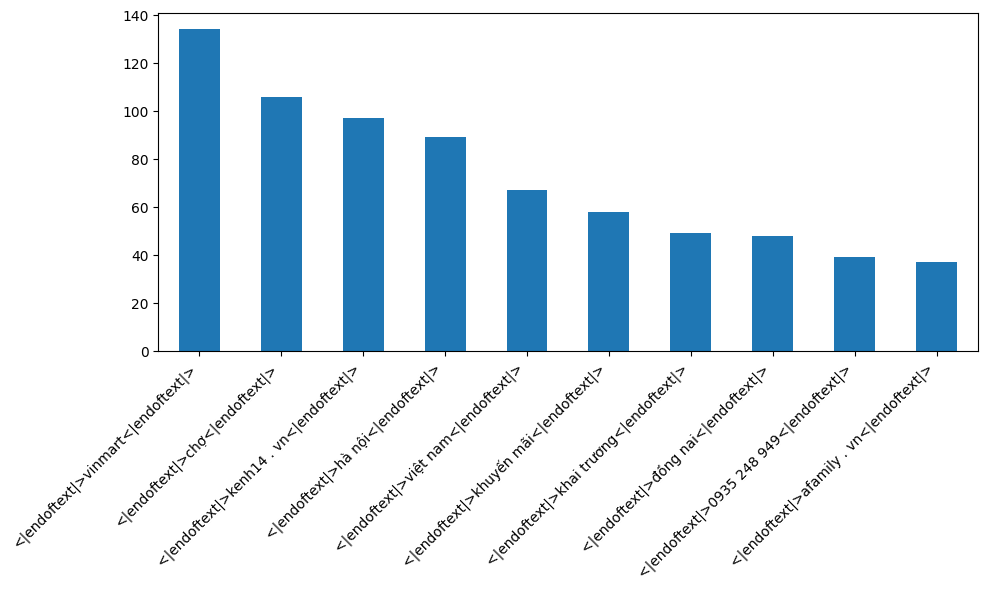

In [9]:
(pd.Series([t['answer'] for t in train_data])
   .value_counts()
   .head(10)
   .plot.bar(figsize=(10,6)))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
train_ds = Dataset.from_dict(
    {key: [item[key] for item in train_data] for key in train_data[0].keys()}
)
val_ds = Dataset.from_dict(
    {key: [item[key] for item in val_data] for key in val_data[0].keys()}
)

In [13]:
val_ds[0]

{'image_id': 22,
 'question_id': 74,
 'question': 'cửa tiệm màu xanh là gì ?',
 'answer': '<|endoftext|>nhà thuốc<|endoftext|>',
 'all_answers': ['nhà thuốc'],
 'image_filename': 'vitextvqa/st_images/22.jpg'}

In [18]:
text_encoder_tokenizer = AutoTokenizer.from_pretrained(TEXT_ENCODER_MODEL)
image_feature_extractor = ViTFeatureExtractor.from_pretrained(IMAGE_ENCODER_MODEL)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [19]:
# Create a transform pipeline
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")
    return img

In [20]:
def data_collator(batch):
    text_inputs = [sample['question'] for sample in batch]
    text_tensors = text_encoder_tokenizer(text_inputs, padding=True, return_tensors="pt")

    processed_images = [preprocess_image(sample["image_filename"]) for sample in batch]
    image_inputs = image_feature_extractor(processed_images)
    image_tensors = torch.from_numpy(np.stack(image_inputs['pixel_values']))

    target_inputs = [sample["answer"] for sample in batch]
    target_tensors = decoder_tokenizer(target_inputs, padding=True, return_tensors="pt")

    labels = target_tensors["input_ids"].clone()
    labels = torch.where((labels == decoder_tokenizer.pad_token_id), -100, labels)
    labels[:, -1] = decoder_tokenizer.eos_token_id

    return {
        "input_text": text_tensors["input_ids"],
        "attention_mask": text_tensors["attention_mask"],
        "input_image": image_tensors,
        "decoder_input_ids": target_tensors["input_ids"],
        "labels": labels
    }

In [21]:
def sanity_check_collator(idx):
    batch = data_collator([train_data[0], train_data[idx]])
    print("Decoder input ids:\n", batch['decoder_input_ids'])
    print("Labels:\n", batch['labels'])

sanity_check_collator(10)

Decoder input ids:
 tensor([[50256,    76,   127,   105,   627,   157,   118,    96,   782,   837,
           275, 21356,    77,   275,   127,   110,   289,    84,   157,   118,
           123, 50256],
        [50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256,  2503,   764,   264,   620, 12384,   764,   410,
            77, 50256]])
Labels:
 tensor([[ -100,    76,   127,   105,   627,   157,   118,    96,   782,   837,
           275, 21356,    77,   275,   127,   110,   289,    84,   157,   118,
           123, 50256],
        [ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  2503,   764,   264,   620, 12384,   764,   410,
            77, 50256]])


## Training the multimodal VQA model

In [14]:
training_args = TrainingArguments(
    output_dir="./vitextvqa_output",
    num_train_epochs=3,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_safetensors=False,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    logging_steps=10,
    report_to='wandb',
    warmup_ratio=0.1,
    learning_rate=2e-5,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    remove_unused_columns=False,
    dataloader_num_workers=4,
)

In [15]:
model = MultimodalVQAModel(
    TEXT_ENCODER_MODEL,
    IMAGE_ENCODER_MODEL,
    DECODER_MODEL
).to(device)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer

In [19]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")

Number of trainable parameters: 375375360


In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
)

In [19]:
def visualize_instance(idx, dataset, model, data_collator, decoder_tokenizer, device="cuda"):
    """
    Visualize a single validation instance:
    - Shows the image
    - Prints the ground truth answer
    - Prints the predicted text and loss
    """

    # Grab a sample
    sample = dataset[idx]

    # Collate into a batch of size 1 and move to device
    batch = data_collator([sample])
    batch = {k: v.to(device) for k, v in batch.items()}

    # Print ground truth
    print(f"Ground truth answer:\n  {sample['answer']}")

    # Forward pass
    model_output = model(**batch)
    output_ids = torch.argmax(model_output.logits, dim=-1)

    # Decode prediction
    decoded_output = decoder_tokenizer.decode(
        output_ids[0],
        skip_special_tokens=True
    ).strip()

    print(f"Predicted output:\n  {decoded_output}")
    print(f"Loss: {model_output.loss.item():.4f}")

    # Show image with question + prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(batch['input_image'][0].cpu().permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Q: {sample['question']}\nPred: {decoded_output}", fontsize=10)
    plt.tight_layout()
    plt.show()

Ground truth answer:
  <|endoftext|>bảo tâm an<|endoftext|>


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Predicted output:
  .��n b�nêhThe
Loss: 5.2818


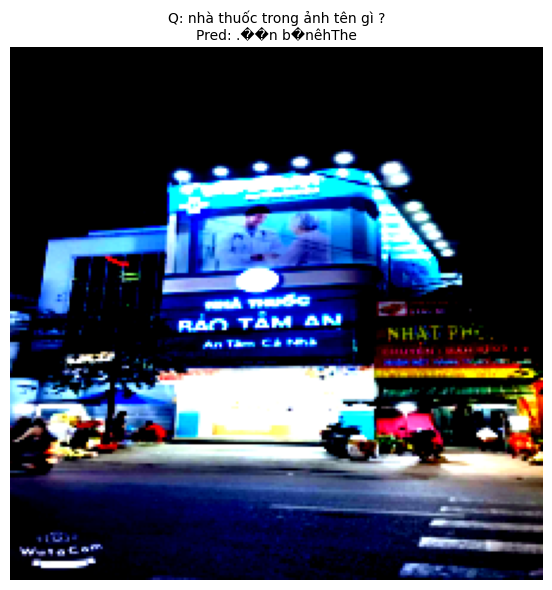

In [22]:
visualize_instance(1, val_ds, model, data_collator, decoder_tokenizer, device)

In [23]:
trainer.evaluate()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ryanhoangt (ryan-nlp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 5.456153392791748,
 'eval_model_preparation_time': 0.0089,
 'eval_runtime': 211.9407,
 'eval_samples_per_second': 24.323,
 'eval_steps_per_second': 0.193}

In [17]:
trainer.train()

wandb: Currently logged in as: ryanhoangt (ryan-nlp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,2.379100,2.321385
2,2.198700,2.141956
3,2.201800,2.102267


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in by

TrainOutput(global_step=3297, training_loss=2.434152381579949, metrics={'train_runtime': 1383.4399, 'train_samples_per_second': 76.243, 'train_steps_per_second': 2.383, 'total_flos': 0.0, 'train_loss': 2.434152381579949, 'epoch': 3.0})

Ground truth answer:
  <|endoftext|>bảo tâm an<|endoftext|>
Predicted output:
  sảo t�m bhn
Loss: 1.6879


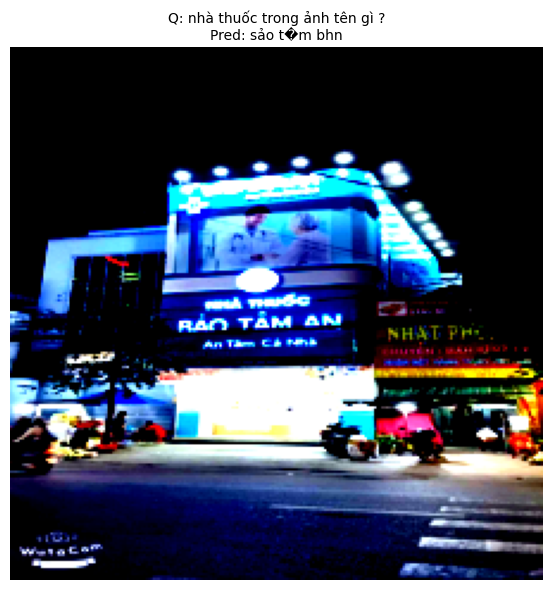

In [20]:
visualize_instance(1, val_ds, model, data_collator, decoder_tokenizer, device)

In [21]:
trainer.save_model()